In [3]:
import datetime, os
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt

from IPython.external import mathjax

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.7.0


In [1]:
import zipfile
import astropy
import glob
from astropy.table import Table
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model

2022-12-08 23:39:45.001965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 23:39:45.002035: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with zipfile.ZipFile('/content/drive/My Drive/archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/My Drive/galaxy images1')

In [4]:
training_class_table_1 = pd.read_csv('training_class_table_1.csv')
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [5]:
del training_class_table_1['Unnamed: 0']
del train_df['Unnamed: 0']
del test_df['Unnamed: 0']


In [6]:
colnames_train = list(training_class_table_1.columns[1:])

In [ ]:
xtrain_intrain = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, 
                                   rotation_range = 20).flow_from_dataframe(
    train_df,
    directory='/content/drive/My Drive/galaxy images1/',
    x_col='GalaxyID',
    y_col=colnames_train,
#     weight_col=None,
    target_size=(77, 77),
    color_mode='rgb',
#     classes=None,
    class_mode='raw',
    batch_size=150,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    subset=None,
    interpolation='nearest',
    validate_filenames=True,
)

xval_intrain = ImageDataGenerator(horizontal_flip = True, vertical_flip = True, 
                                   rotation_range = 20).flow_from_dataframe(
    test_df,
    directory='/content/drive/My Drive/galaxy images1/',
    x_col='GalaxyID',
    y_col=colnames_train,
#     weight_col=None,
    target_size=(77, 77),
    color_mode='rgb',
#     classes=None,
    class_mode='raw',
    batch_size=150,
    shuffle=False,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='jpg',
    subset=None,
    interpolation='nearest',
    validate_filenames=True,
)

Found 49262 validated image filenames.
Found 12316 validated image filenames.


In [ ]:
K.clear_session()

model = Sequential()
pretrained_model = ResNet50(include_top = False, 
                            input_shape = (77, 77, 3), pooling = 'avg', 
                            classes = 37, 
                            weights='imagenet') #say what imagenet does in report
# for layer in pretrained_model.layers: #SAVES MAJOR TIME
#         layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(37, activation='sigmoid')) #NUMBER OF LABELS
# model.save('model1')

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 37)                75813     
                                                                 
Total params: 23,663,525
Trainable params: 23,610,405
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
                loss='mse',
                metrics=[tf.keras.metrics.RootMeanSquaredError(), 'accuracy'])

In [ ]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes') 
# define path to save model 
model_path = f'/content/drive/My Drive/nn_results_resnet/datalab_nn_{run_time_string}.h5' 
print(f"Training ... {model_path}") 
model.save(model_path) 

logdir = os.path.join("/content/drive/My Drive/nn_results_resnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) 

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='root_mean_square_error', factor=0.75, 
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0) 

csv_logger = tf.keras.callbacks.CSVLogger(f'/content/drive/My Drive/nn_results_resnet/training_{run_time_string}.log') 

earlystop = tf.keras.callbacks.EarlyStopping(monitor='root_mean_square_error', min_delta=0.001, 
                                             patience=3,  
                                             verbose=1, mode='auto') 

model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
        monitor='root_mean_square_error', 
        save_best_only=True, 
        mode='min', 
        verbose=1) 

model.fit(x=xtrain_intrain, 
          epochs = 22, 
          validation_data=xval_intrain, 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check]) 

Training ... /content/drive/My Drive/nn_results_resnet/datalab_nn_2022-12-08T07:50.h5
Epoch 1/22
329/329 [==============================] - 225s 633ms/step - loss: 0.0131 - root_mean_squared_error: 0.1147 - accuracy: 0.7210 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244 - val_accuracy: 0.6885 - lr: 0.0010
Epoch 2/22
329/329 [==============================] - 196s 595ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - accuracy: 0.7667 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041 - val_accuracy: 0.7669 - lr: 0.0010
Epoch 3/22
329/329 [==============================] - 196s 594ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957 - accuracy: 0.7767 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1047 - val_accuracy: 0.7550 - lr: 0.0010
Epoch 4/22
329/329 [==============================] - 196s 595ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - accuracy: 0.7830 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178 - val_accuracy: 0.6269 - l

In [ ]:
latest_log_file = !ls -t1 /content/drive/My\ Drive/nn_results_resnet/training* | head -1
latest_model_file = !ls -t1 /content/drive/My\ Drive/nn_results_resnet/datalab_*.h5 | head -1

hist_df = pd.read_csv(latest_log_file[0])
hist_df

,epoch,accuracy,loss,lr,root_mean_squared_error,val_accuracy,val_loss,val_root_mean_squared_error
0,0,0.720961,0.013146,0.001,0.114656,0.688454,0.015478,0.124411
1,1,0.766717,0.009681,0.001,0.098392,0.766889,0.010838,0.104106
2,2,0.776664,0.009155,0.001,0.095680,0.754953,0.010968,0.104728
3,3,0.782977,0.008770,0.001,0.093648,0.626908,0.013869,0.117766
4,4,0.786286,0.008523,0.001,0.092321,0.758444,0.009473,0.097327
5,5,0.788417,0.008305,0.001,0.091132,0.744073,0.010487,0.102405
6,6,0.793208,0.008126,0.001,0.090142,0.688616,0.010679,0.103339
7,7,0.794101,0.008030,0.001,0.089613,0.787512,0.008871,0.094187
8,8,0.795928,0.007930,0.001,0.089051,0.780692,0.009973,0.099866
9,9,0.799825,0.007754,0.001,0.088057,0.756577,0.010447,0.102210


In [ ]:
def plot_loss1(hist_df, epochs):    
    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    ax[0].plot(hist_df['epoch'], np.sqrt(hist_df['loss']), label = 'Training Loss')
    ax[0].scatter(hist_df['epoch'], np.sqrt(hist_df['loss']), color = 'blue')

    ax[0].plot(hist_df['epoch'], np.sqrt(hist_df['val_loss']), label = 'Validation Loss')
    ax[0].scatter(hist_df['epoch'], np.sqrt(hist_df['val_loss']), color = 'orange')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Root Mean Squared Error Loss')
    ax[0].set_xticks(range(0, epochs))
    ax[0].set_title('Training vs. Validation RMSE Loss Plot')
    ax[0].legend()

    ax[1].plot(hist_df['epoch'], hist_df['accuracy'], label = 'Training Accuracy')
    ax[1].scatter(hist_df['epoch'], hist_df['accuracy'], color = 'blue')
    ax[1].plot(hist_df['epoch'], hist_df['val_accuracy'], label = 'Validation Accuracy')
    ax[1].scatter(hist_df['epoch'], hist_df['val_accuracy'], color = 'orange')
    ax[1].set_title('Training vs. Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xticks(range(0, epochs))
    return ax[1].legend()

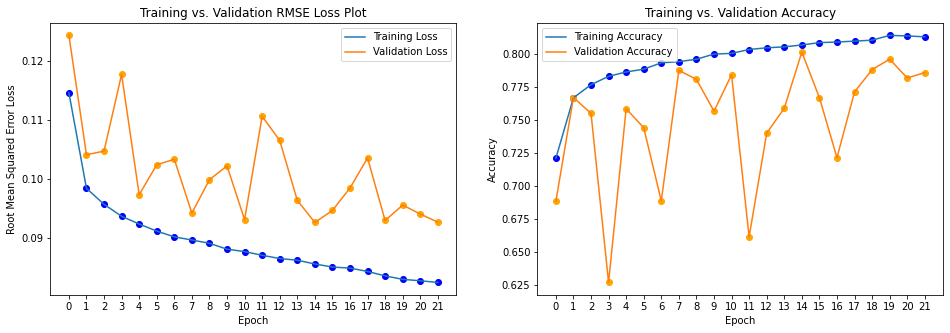

In [ ]:
plot_loss1(hist_df, 22)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
testing_it = load_model(model_path)

In [ ]:
testpredict = testing_it.predict(xval_intrain)

83/83 [==============================] - 38s 446ms/step


In [ ]:
testpredict.shape

(12316, 37)

In [ ]:
true_labels = np.array(test_df.iloc[:,1:])
true_labels.shape

(12316, 37)

In [17]:
from tensorflow.keras.preprocessing import image

In [18]:
filepath = '/content/drive/My Drive/galaxy images1/*'
filepath1 = '/content/drive/My Drive/galaxy images1/'
filepath2 = 'COMPRESSED 4/'

In [ ]:
a = glob.glob(filepath2)

In [19]:
id_paths_test = []
for id in np.array(test_df.iloc[:, 0]):
  id_with_path = filepath2 + id 
  id_paths_test.append(id_with_path)
id_paths_test[0]

'COMPRESSED 4/471191.jpg'

In [20]:
len(id_paths_test)

12316

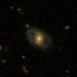

In [ ]:
the_images = []
for test_ids in id_paths_test:
  readit = image.load_img(test_ids, target_size = (77, 77))
  the_images.append(readit)
the_images[0]

In [ ]:
test_arrays = []
for pics in the_images:
  arr = image.img_to_array(pics)
  test_arrays.append(arr)

In [ ]:
test_expanded = []
for arr in test_arrays:
  expanded = np.expand_dims(arr, axis = 0)
  test_expanded.append(expanded)

len(test_expanded)

12316

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
predictions = []
for boop in test_expanded:
  preds = model.predict(boop)
  predictions.append(preds)

# predictions.shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step


AttributeError: ignored

In [ ]:
# prediction_1 = model.predict(transformedImage1)
# prediction_2 = model.predict(transformedImage2)
# prediction_3 = model.predict(transformedImage3)
# prediction_4 = model.predict(transformedImage4)
# prediction_5 = model.predict(transformedImage5)

In [ ]:
prediction_list = []
for things in predictions:
  beep = things.tolist()
  bop = sum(beep, [])
  prediction_list.append(bop)

In [ ]:
all_test_preds = np.array(prediction_list)

In [ ]:
true_labels_test = np.array(test_df.iloc[:, 1:38])
true_labels_test.shape

(12316, 37)

In [ ]:
# true_1 = np.array(training_class_table_1.iloc[0, :][1:])
# true_2 = np.array(training_class_table_1.iloc[888, :][1:])
# true_3 = np.array(training_class_table_1.iloc[8888, :][1:])
# true_4 = np.array(training_class_table_1.iloc[29384, :][1:])
# true_5 = np.array(training_class_table_1.iloc[58237, :][1:])

Text(0.5, 1.0, 'True vs. Predicted Labels (Model 3)')

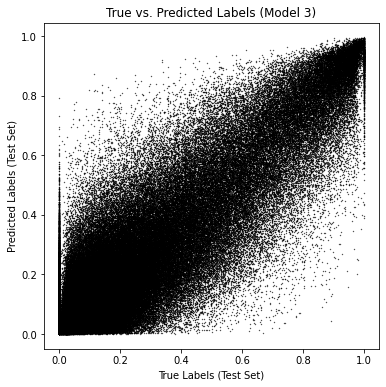

In [ ]:
plt.figure(figsize = (6, 6))
plt.scatter(true_labels_test, all_test_preds, color = 'black', s = 0.1)
plt.xlabel('True Labels (Test Set)')
plt.ylabel('Predicted Labels (Test Set)')
plt.title('True vs. Predicted Labels (Model 3)')

**SMOOTH**

In [167]:
test_df_pred = pd.read_csv('test_df_pred.csv')
del test_df_pred['Unnamed: 0']

In [168]:
import matplotlib.image as mpimg

In [169]:
def topfive(df, df_pred, column):
    five = df.sort_values(by = column, ascending = False).iloc[0:5, :]
    five_test = df_pred.sort_values(by = column, ascending = False).iloc[0:5, :]
    imgs = []
    names = []
    for jpgs in np.array(five.iloc[:,0]):
        good = filepath2 + jpgs
        pics = mpimg.imread(good)
        imgs.append(pics)
        names.append(jpgs[:-4])
        
    imgs_test = []
    names_test = []
    for jpgs in np.array(five_test.iloc[:,0]):
        good = filepath2 + jpgs
        pics = mpimg.imread(good)
        imgs_test.append(pics)
        names_test.append(jpgs[:-4])
        
    fig1, ax1 = plt.subplots(1, 5, figsize = (18, 3))
    for i in range(5):
        ax1[i].imshow(imgs[i])
        ax1[i].set_title(names[i])
        ax1[i].axis('off')
        
    fig2, ax2 = plt.subplots(1, 5, figsize = (18, 3))
    for i in range(5):
        ax2[i].imshow(imgs_test[i])
        ax2[i].set_title(names_test[i])
        ax2[i].axis('off')
        
    fig2.suptitle(column + ' (Model 3 predicted)', fontsize = 14, y = 1.1)
    return fig1.suptitle(column + ' (true label)', fontsize = 14, y = 1.1)

**SMOOTH**

Text(0.5, 1.1, 'Task 01: smooth (true label)')

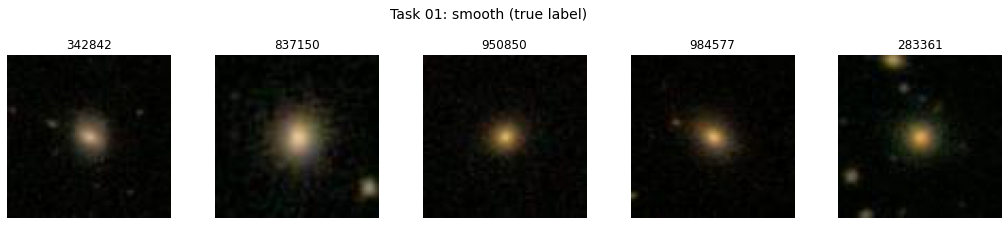

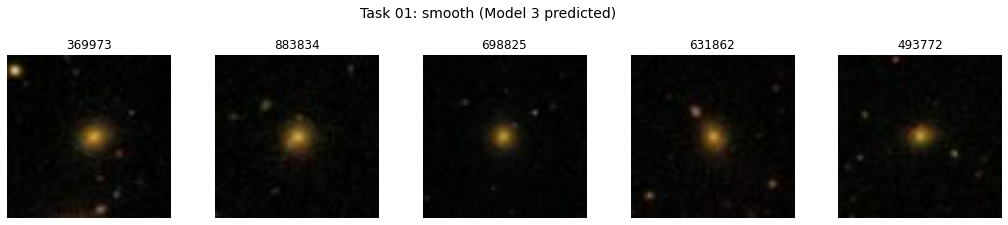

In [170]:
topfive(test_df, test_df_pred, 'Task 01: smooth')

**STAR OR ARTIFACT**

Text(0.5, 1.1, 'Task 01: star or artifact (true label)')

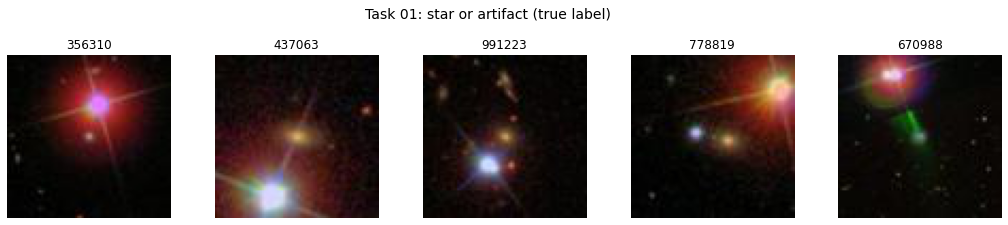

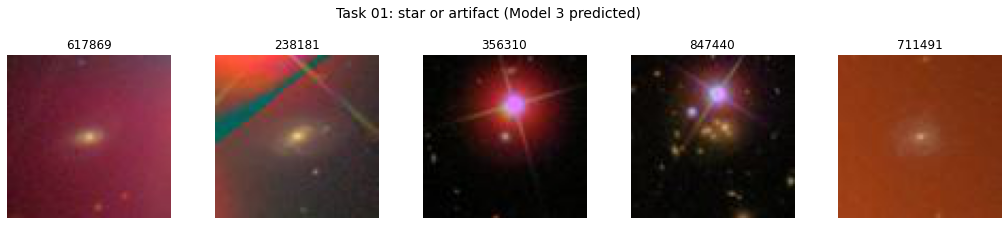

In [155]:
topfive(test_df, test_df_pred, 'Task 01: star or artifact')

**EDGE-ON/DISK**

Text(0.5, 1.1, 'Task 02: edge-on (true label)')

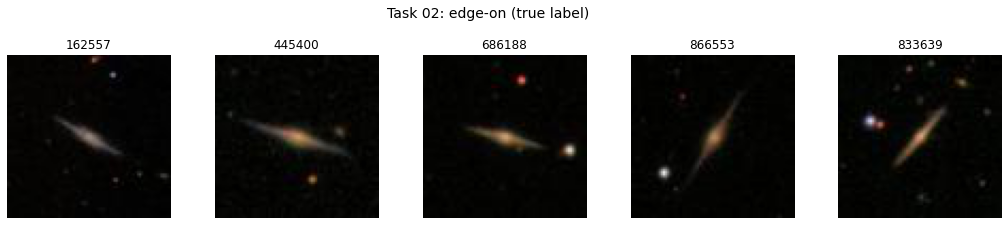

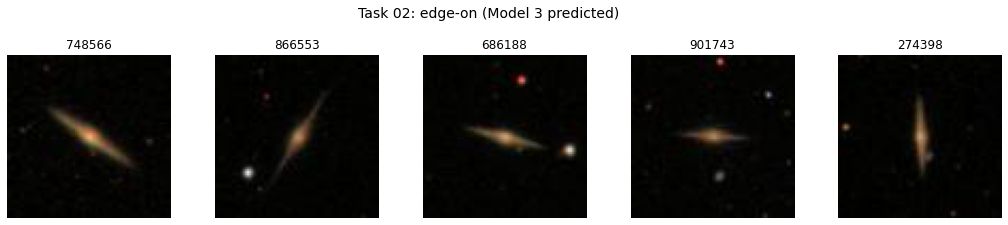

In [156]:
topfive(test_df, test_df_pred, 'Task 02: edge-on')

**ODD RING**

Text(0.5, 1.1, 'Task 08: odd feature ring (true label)')

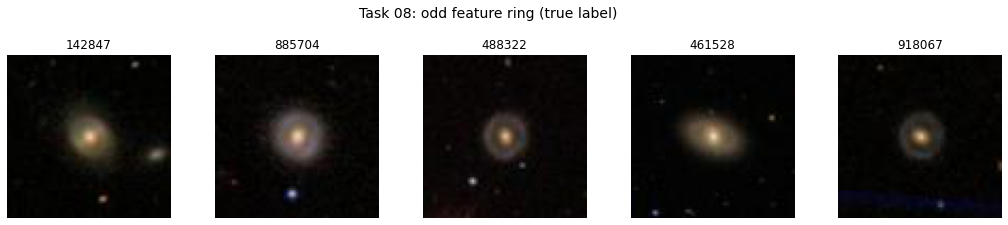

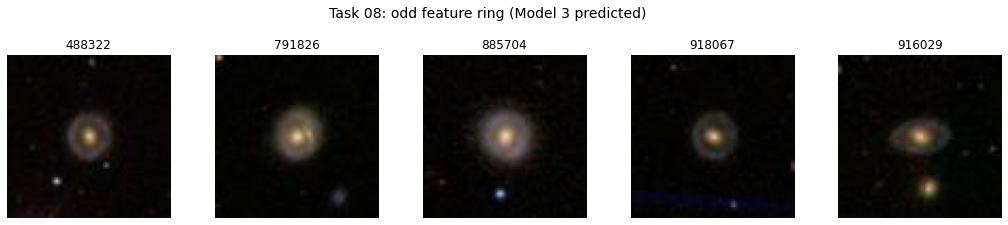

In [159]:
topfive(test_df, test_df_pred, 'Task 08: odd feature ring')

**ODD LENS/ARC**

Text(0.5, 1.1, 'Task 08: odd feature lens or arc (true label)')

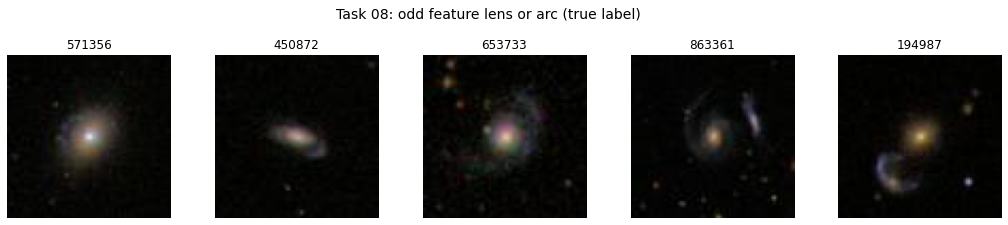

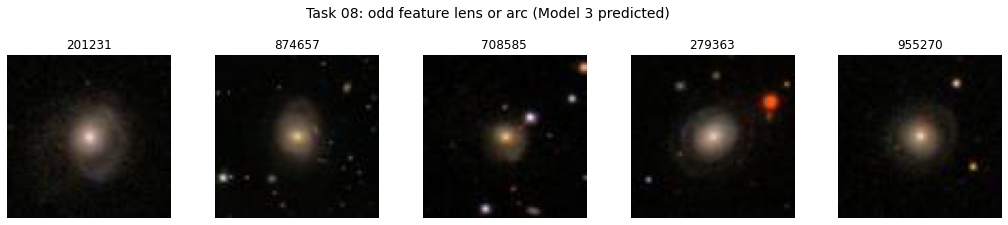

In [161]:
topfive(test_df, test_df_pred, 'Task 08: odd feature lens or arc')

**SPIRAL**

Text(0.5, 1.1, 'Task 11: 2 arms (true label)')

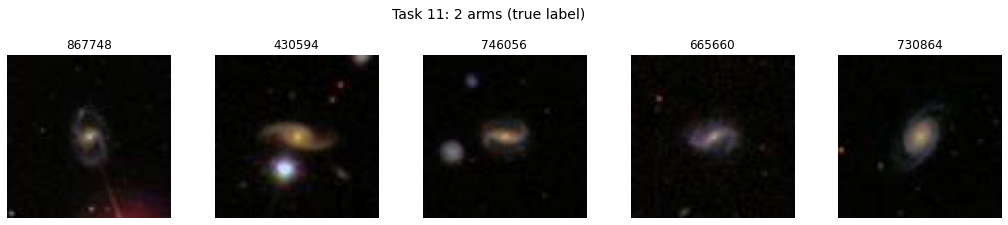

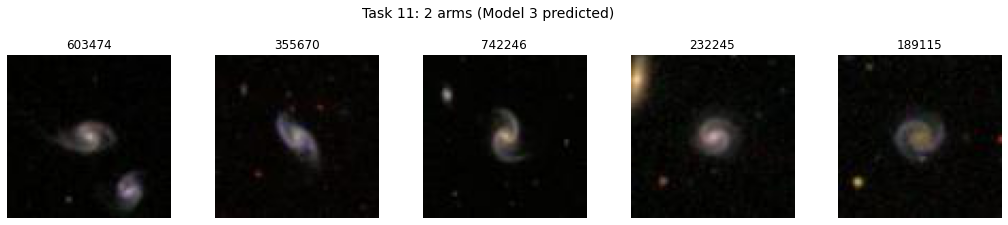

In [165]:
topfive(test_df, test_df_pred, 'Task 11: 2 arms')

Text(0.5, 1.1, 'Task 08: odd feature merger (true label)')

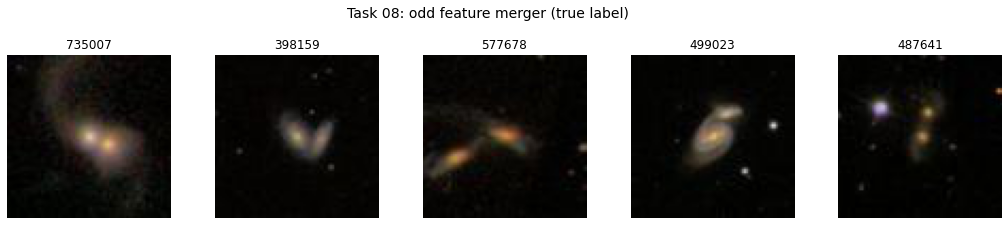

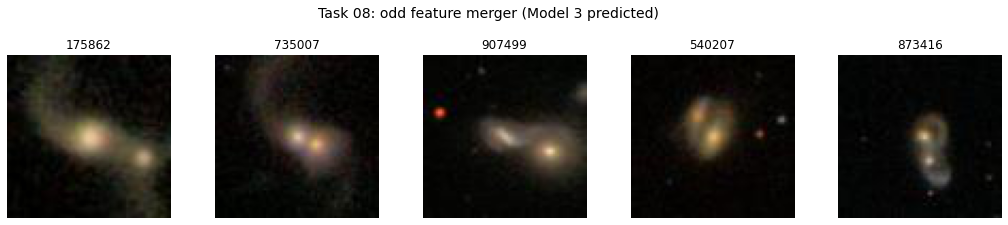

In [166]:
topfive(test_df, test_df_pred, 'Task 08: odd feature merger')